In [27]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [28]:
# Read in the given data and set the index column to the date column and parse the dates
df=pd.read_csv("../../02_data_acquisition_understanding/01_data_source/sickness_table.csv", index_col="date", parse_dates=True ) 
df["drivers_atwork"]=df["n_duty"]+df["sby_need"]
df.index.freq="D" #Set the frequence to Daily
df.index

DatetimeIndex(['2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10',
               ...
               '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-21',
               '2019-05-22', '2019-05-23', '2019-05-24', '2019-05-25',
               '2019-05-26', '2019-05-27'],
              dtype='datetime64[ns]', name='date', length=1152, freq='D')

In [29]:
# Prepare the Data for Prophet
# Create the column "date"
df["date"]=df.index
# Create new DataFrames with the column "date"
df_new=pd.DataFrame(df["date"])
# Create the column y="calls"
df_new["y"]=df["calls"]
# Delete the index
df_new.reset_index(drop=True, inplace=True)
# Rename the columns to the Prophet specifics
df_new.rename(columns={"date": "ds", "y": "y"}, inplace=True)
# Show the head of the DataFrame
df_new.head()

,ds,y
0,2016-04-01,8154.0
1,2016-04-02,8526.0
2,2016-04-03,8088.0
3,2016-04-04,7044.0
4,2016-04-05,7236.0


In [30]:
# Split the Data in a test and a split data set
train = df_new.iloc[:len(df_new)-365]
test = df_new.iloc[len(df_new)-365:]
test.set_index(test["ds"], inplace=True)
# Get the time window for the predicted times  
df_new.iloc[len(df_new)-365:]

,ds,y
787,2018-05-28,8862.0
788,2018-05-29,8226.0
789,2018-05-30,8064.0
790,2018-05-31,7392.0
791,2018-06-01,10752.0
...,...,...
1147,2019-05-23,8544.0
1148,2019-05-24,8814.0
1149,2019-05-25,9846.0
1150,2019-05-26,9882.0


In [31]:
test

,ds,y
ds,,
2018-05-28,2018-05-28,8862.0
2018-05-29,2018-05-29,8226.0
2018-05-30,2018-05-30,8064.0
2018-05-31,2018-05-31,7392.0
2018-06-01,2018-06-01,10752.0
...,...,...
2019-05-23,2019-05-23,8544.0
2019-05-24,2019-05-24,8814.0
2019-05-25,2019-05-25,9846.0


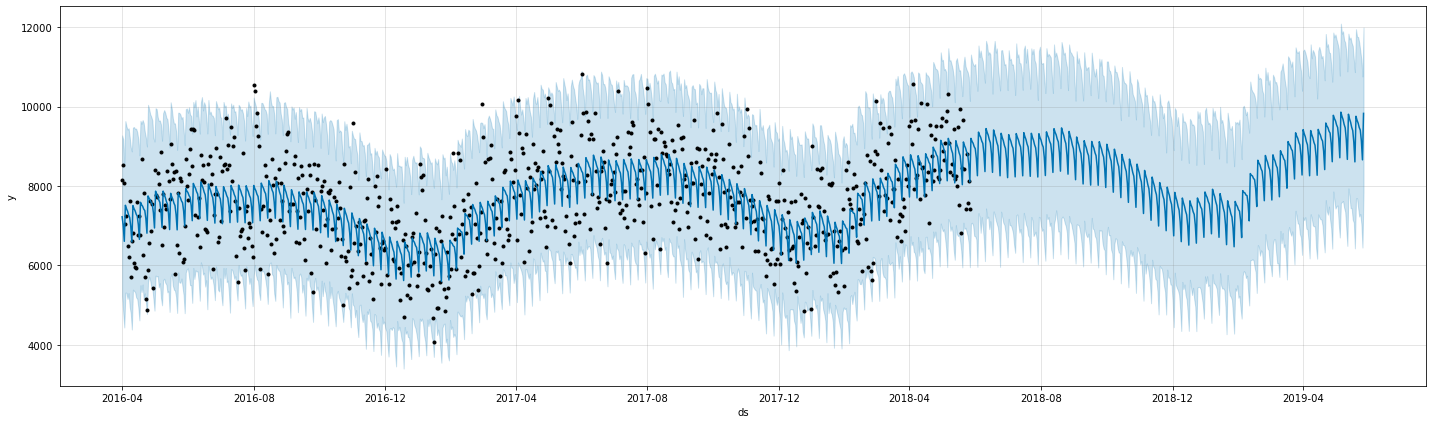

In [32]:
#Create the Prohpet-Model,with an interval_width of 97,5% (97,5% of the train values are in the predicted range) 
m = Prophet(interval_width=0.975, daily_seasonality=True,seasonality_mode="multiplicative")
# Train the Prophet-Model
m.fit(train)
# Create future datafame with xx days (periods & freq) as basis for prediction
future = m.make_future_dataframe(periods=365,freq='D')
# Make predictions for the created future dataframe
forecast = m.predict(future)
#plot the predictions 
m.plot(forecast, figsize=(20, 6));
forecast.set_index(forecast["ds"], inplace=True)
forecast["n_RealCalls"]=df["calls"]

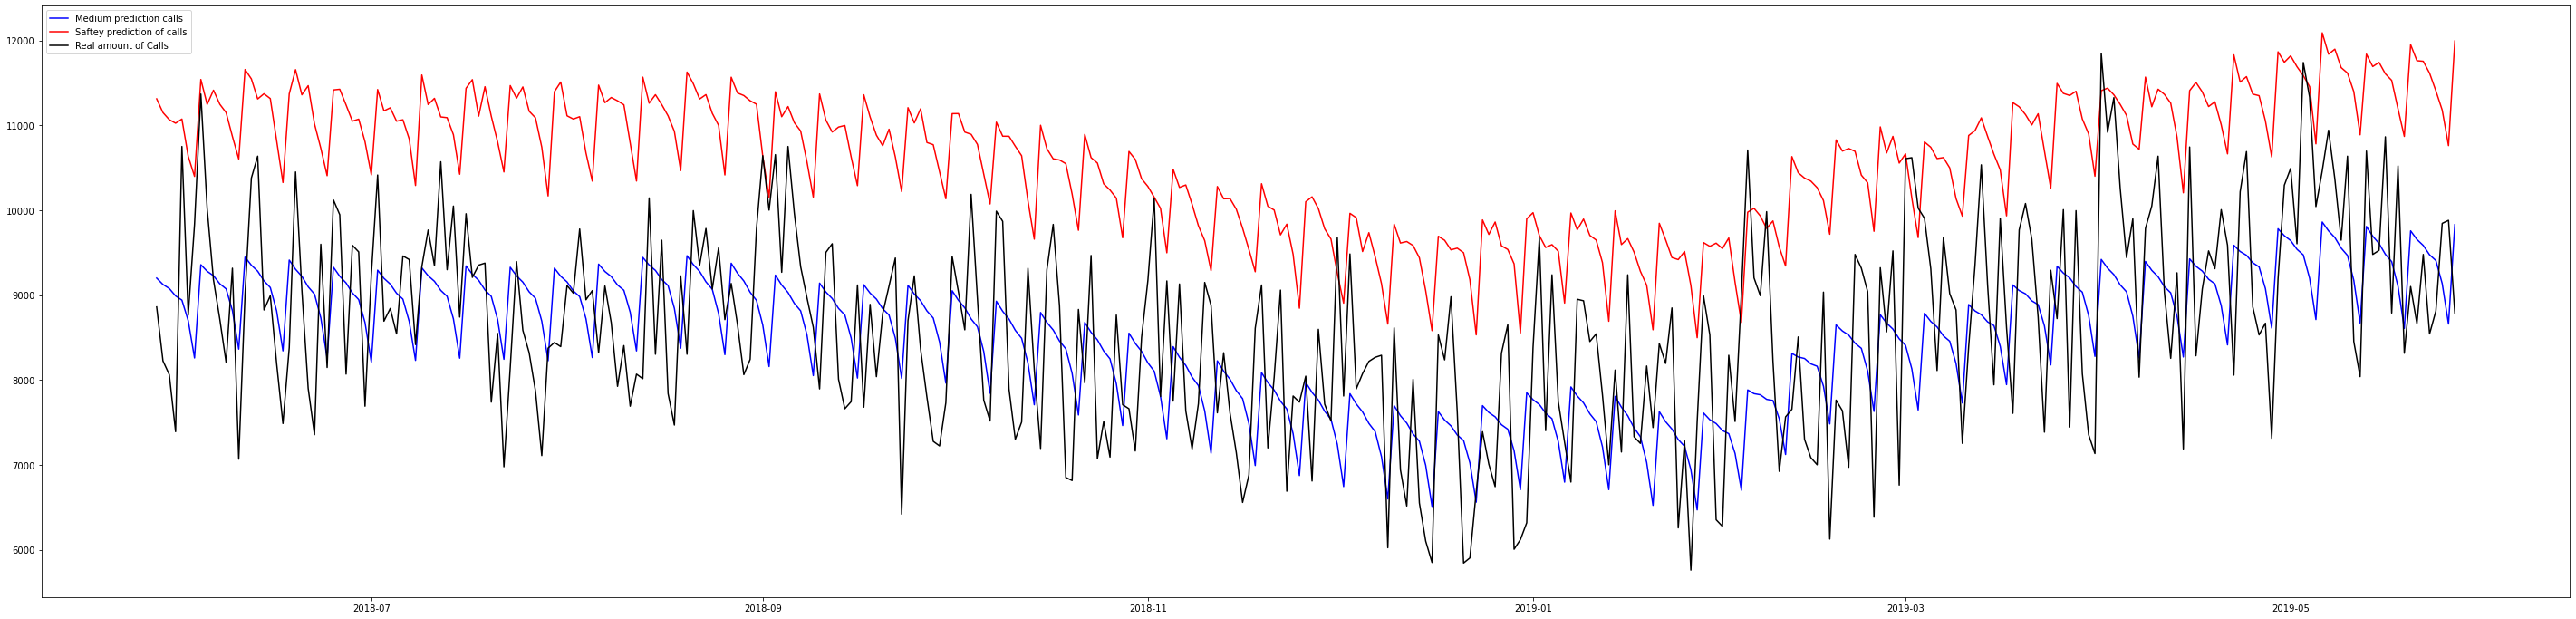

In [33]:
fig = plt.figure(figsize=(50,12))
ax = fig.add_subplot(1, 1, 1)
ax.plot(forecast["ds"].iloc[len(forecast)-365:], forecast["yhat"].iloc[len(forecast)-365:],  label='Medium prediction calls', c="blue")
ax.plot(forecast["ds"].iloc[len(forecast)-365:], forecast["yhat_upper"].iloc[len(forecast)-365:], label='Saftey prediction of calls', c="red")
ax.plot(forecast["ds"].iloc[len(forecast)-365:],forecast["n_RealCalls"].iloc[len(forecast)-365:],label="Real amount of Calls", c="black")
ax.legend(loc='upper left')


Min_MSEError 196.22728826407905
Best linear_coef value:  4.822822822822823


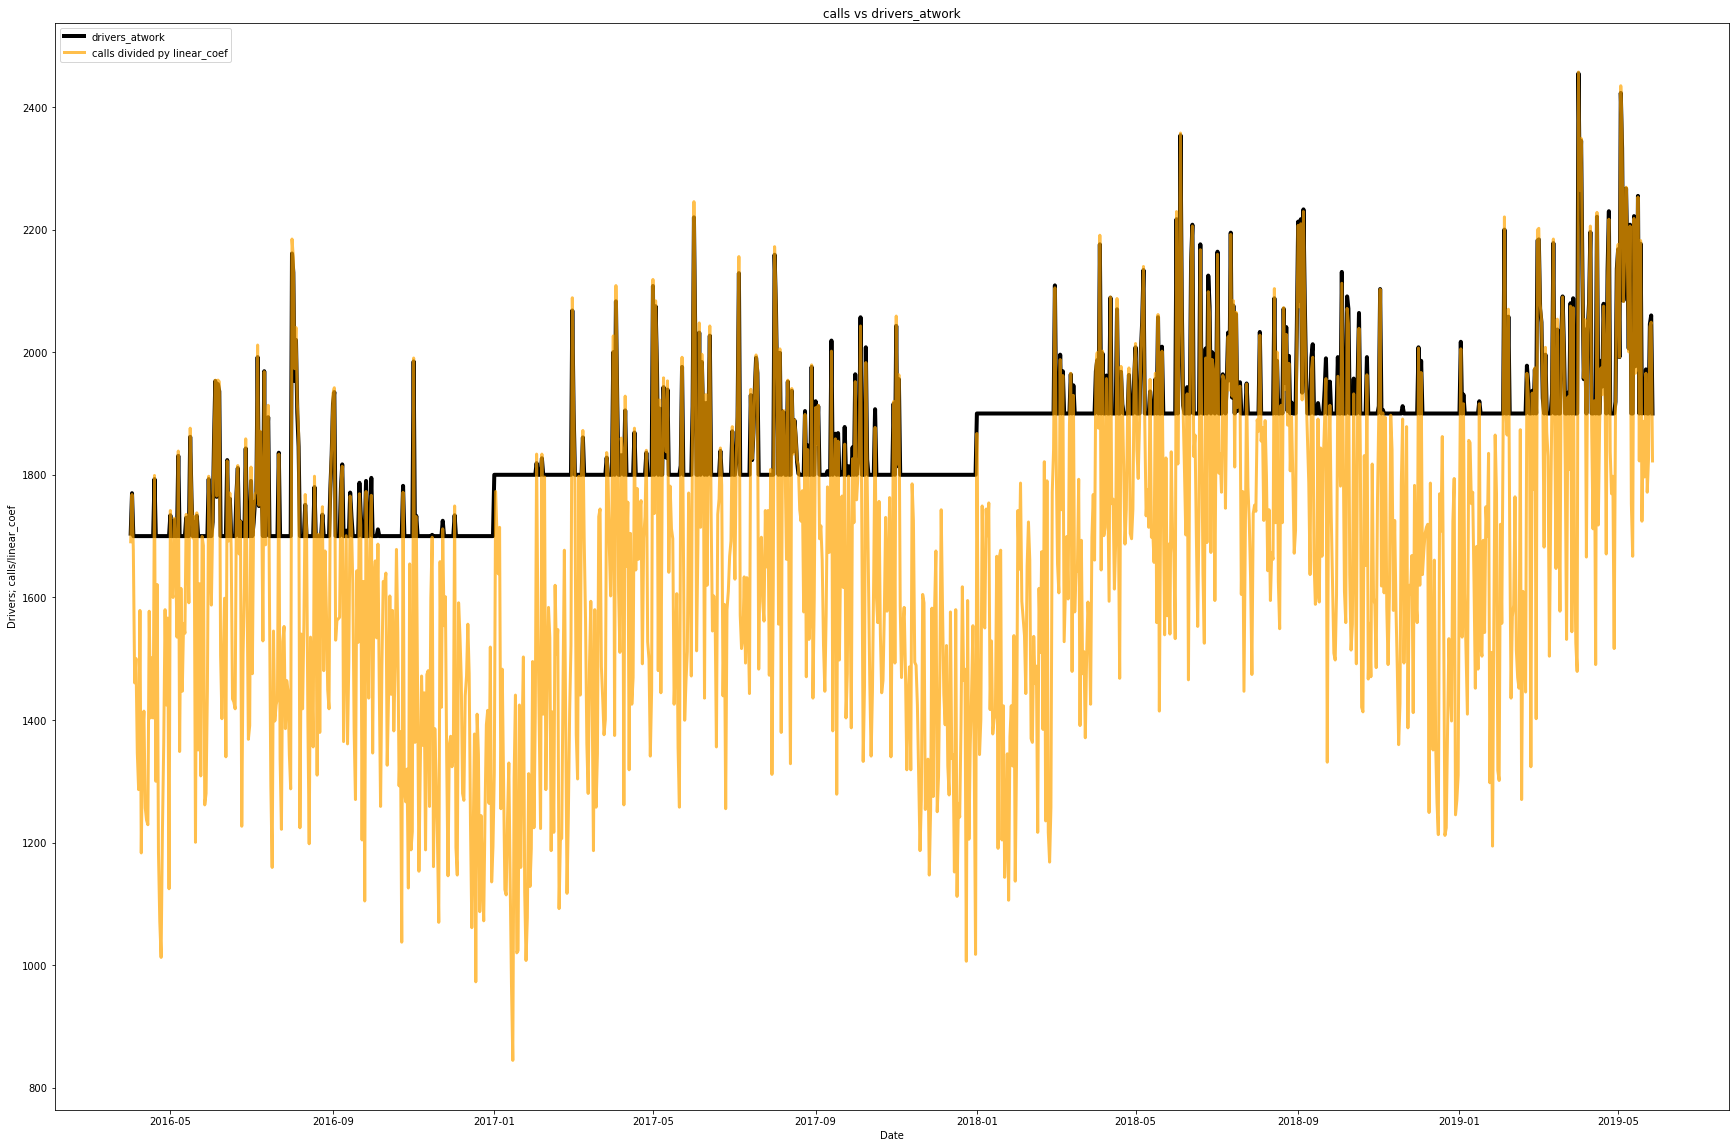

In [34]:
#ratio calls/ drivers: 
#adjust the dataframe by the values where the base line is hit
df_adjusted = df.loc[df["drivers_atwork"] != 1770.0]
df_adjusted = df_adjusted.loc[df_adjusted["drivers_atwork"] != 1700.0]
df_adjusted = df_adjusted.loc[df_adjusted["drivers_atwork"] != 1800.0]
df_adjusted = df_adjusted.loc[df_adjusted["drivers_atwork"] != 1900.0]
df_adjusted.head()

Min_MSEError=10**1000
x_Value=0
for x in np.linspace(2, 6, num=1000):
    ErrorSUM=0
    #print(x)
    for counter1 in range(0,len(df_adjusted)):
        a=float(df_adjusted.iloc[counter1, 7]) # drivers_atwork
        b=float(df_adjusted.iloc[counter1, 2]) # calls
        ErrorSUM=ErrorSUM + (a-(b/x))**2
    if Min_MSEError > (ErrorSUM/len(df_adjusted)):
        Min_MSEError=ErrorSUM/len(df_adjusted)
        x_Value=x
        
print ("Min_MSEError", Min_MSEError)
print("Best linear_coef value: ", x_Value)


fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)
ax.set_title('calls vs drivers_atwork')
plt.plot(df["drivers_atwork"],color='black',label='drivers_atwork', lw=4)
plt.plot(df["calls"]/x_Value,color='orange',label="calls divided py linear_coef", alpha=0.7, lw=3)
ax.set_xlabel('Date')
ax.set_ylabel('Drivers; calls/linear_coef')
ax.legend(loc='upper left')
plt.show()


In [35]:
#List of interval_width to be evaluated
liste=[0.7,0.75,0.80, 0.85, 0.9,0.95,0.975, 0.99]

data=[]
for i in liste:
    #Create the Prohpet-Model,with an interval_width of 95% (95% of the train values are in the predicted range) 
    m = Prophet(interval_width=i, daily_seasonality=True,seasonality_mode="multiplicative")
    # Train the Prophet-Model
    m.fit(train)
    # Create future datafame with xx days (periods & freq) as basis for prediction
    future = m.make_future_dataframe(periods=365,freq='D')
    # Make predictions for the created future dataframe
    forecast = m.predict(future)
    #plot the predictions 
    #m.plot(forecast, figsize=(20, 6));
    forecast.set_index(forecast["ds"], inplace=True)
    forecast["n_RealCalls"]=df["calls"]


    df_eval=pd.DataFrame(forecast["ds"].iloc[len(forecast)-365:])
    df_eval["pred_n_duty"]=forecast["yhat"].iloc[len(forecast)-365:]/x_Value
    df_eval["pred_n_sby"]=forecast["yhat_upper"].iloc[len(forecast)-365:]/x_Value-forecast["yhat"].iloc[len(forecast)-365:]/x_Value
    df_eval["real_drivers_atwork"]=df["drivers_atwork"].iloc[len(forecast)-365:]
    df_eval["Delta"]=df_eval["pred_n_duty"]-df_eval["real_drivers_atwork"]
    df_eval["Delta2"]=df_eval["pred_n_duty"] + df_eval["pred_n_sby"] -df_eval["real_drivers_atwork"]

    df_eval["pred_sbyNeed"]= df_eval["Delta"].apply(lambda x: -x if x < 0 else 0)
    df_eval["pred_dafted"]= df_eval["Delta2"].apply(lambda x: -x if x < 0 else np.nan)
    df_eval["pred_utilizationSby"]=df_eval["pred_sbyNeed"]/df_eval["pred_n_sby"]
    df_eval["pred_utilizationSby"]= df_eval["pred_utilizationSby"].apply(lambda x: x if x < 1 else 1)

    df_eval["real_n_sby"]=df["n_sby"].iloc[len(forecast)-365:]
    df_eval["real_sby_need"]=df["sby_need"].iloc[len(forecast)-365:]
    df_eval["real_dafted"]=df["dafted"].iloc[len(forecast)-365:]
    utilization=df_eval["pred_utilizationSby"].mean()
    Overexceed=df_eval["pred_dafted"].count()/365  
    FTE_shifte_needed=df_eval["pred_n_duty"].sum() + df_eval["pred_sbyNeed"].sum()
    FTE_standbyShifts_withoutDuty_needed=df_eval["pred_n_sby"].sum() - df_eval["pred_sbyNeed"].sum() + df_eval["pred_dafted"].iloc[len(df)-365:].sum()
    
  
        
    data.append([i, utilization, Overexceed,FTE_shifte_needed,FTE_standbyShifts_withoutDuty_needed])

    
    #print(f'Schritt-{i}:In the last 365 days {df_eval["pred_n_duty"].sum() + df_eval["pred_sbyNeed"].sum()} FTE shifts we needed')
    #print(f'Schritt-{i}:In the last 365 days {df_eval["pred_n_sby"].sum() - df_eval["pred_sbyNeed"].sum() + df_eval["pred_dafted"].iloc[len(df)-365:].sum()} FTE shifts were hold on standby and were not needed')
    #print(f"Schritt-{i}: The utilization of the standby drivers is: {utilization}, and the number of standby drivers is exeeded in: {Overexceed} 5 over one year")

cols=['interval_width', 'Utilization_ofStandby_%', 'Standby_exceeded_%', 'FTE_shifte_needed', 'FTE_standbyShifts_withoutDuty_needed']
df_result= pd.DataFrame(data, columns=cols)
df_result.set_index("interval_width", inplace=True)
df_result


,Utilization_ofStandby_%,Standby_exceeded_%,FTE_shifte_needed,FTE_standbyShifts_withoutDuty_needed
interval_width,,,,
0.700,0.681972,0.454795,714844.426749,2016.720380
0.750,0.659824,0.432877,714844.426749,10340.131240
0.800,0.630474,0.358904,714844.426749,19844.493298
0.850,0.599755,0.306849,714844.426749,30698.786910
0.900,0.555172,0.230137,714844.426749,45843.909901
0.950,0.495772,0.117808,714844.426749,67919.806416
0.975,0.442822,0.065753,714844.426749,88130.147749
0.990,0.393779,0.030137,714844.426749,111117.289235


In [36]:
#df_eval.to_csv("PredictionResults.csv", sep=";", decimal=",")
#df_eval

In [37]:
#df_result["Utilization_ofStandby_%"].plot(figsize=(12,8), grid =True)
#df_result["Standby_exceeded_%"].plot()

In [38]:
#fig, ax1 = plt.subplots()
#ax2 = ax1.twinx()
#ax1.plot(df_result.index,df_result["Utilization_ofStandby_%"], 'g-')
#ax1.plot( df_result.index,df_result["Standby_exceeded_%"], 'g-')
#ax2.plot( df_result.index,df_result["FTE_standbyShifts_withoutDuty_needed"], 'r-')
#
#ax1.set_xlabel('X data')
#ax1.set_ylabel('Y1 data', color='g')
#ax2.set_ylabel('Y2 data', color='b')
#plt.show()

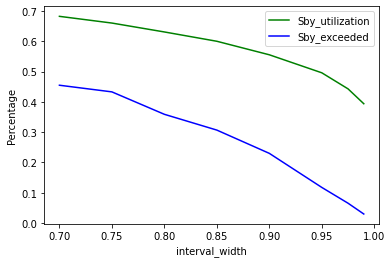

In [39]:
fig, ax1 = plt.subplots()
ax1.plot(df_result.index,df_result["Utilization_ofStandby_%"], 'g-', label="Sby_utilization")
ax1.plot( df_result.index,df_result["Standby_exceeded_%"], 'b-', label="Sby_exceeded")

ax1.set_xlabel('interval_width')
ax1.set_ylabel('Percentage', color='black')
plt.legend()
plt.show()

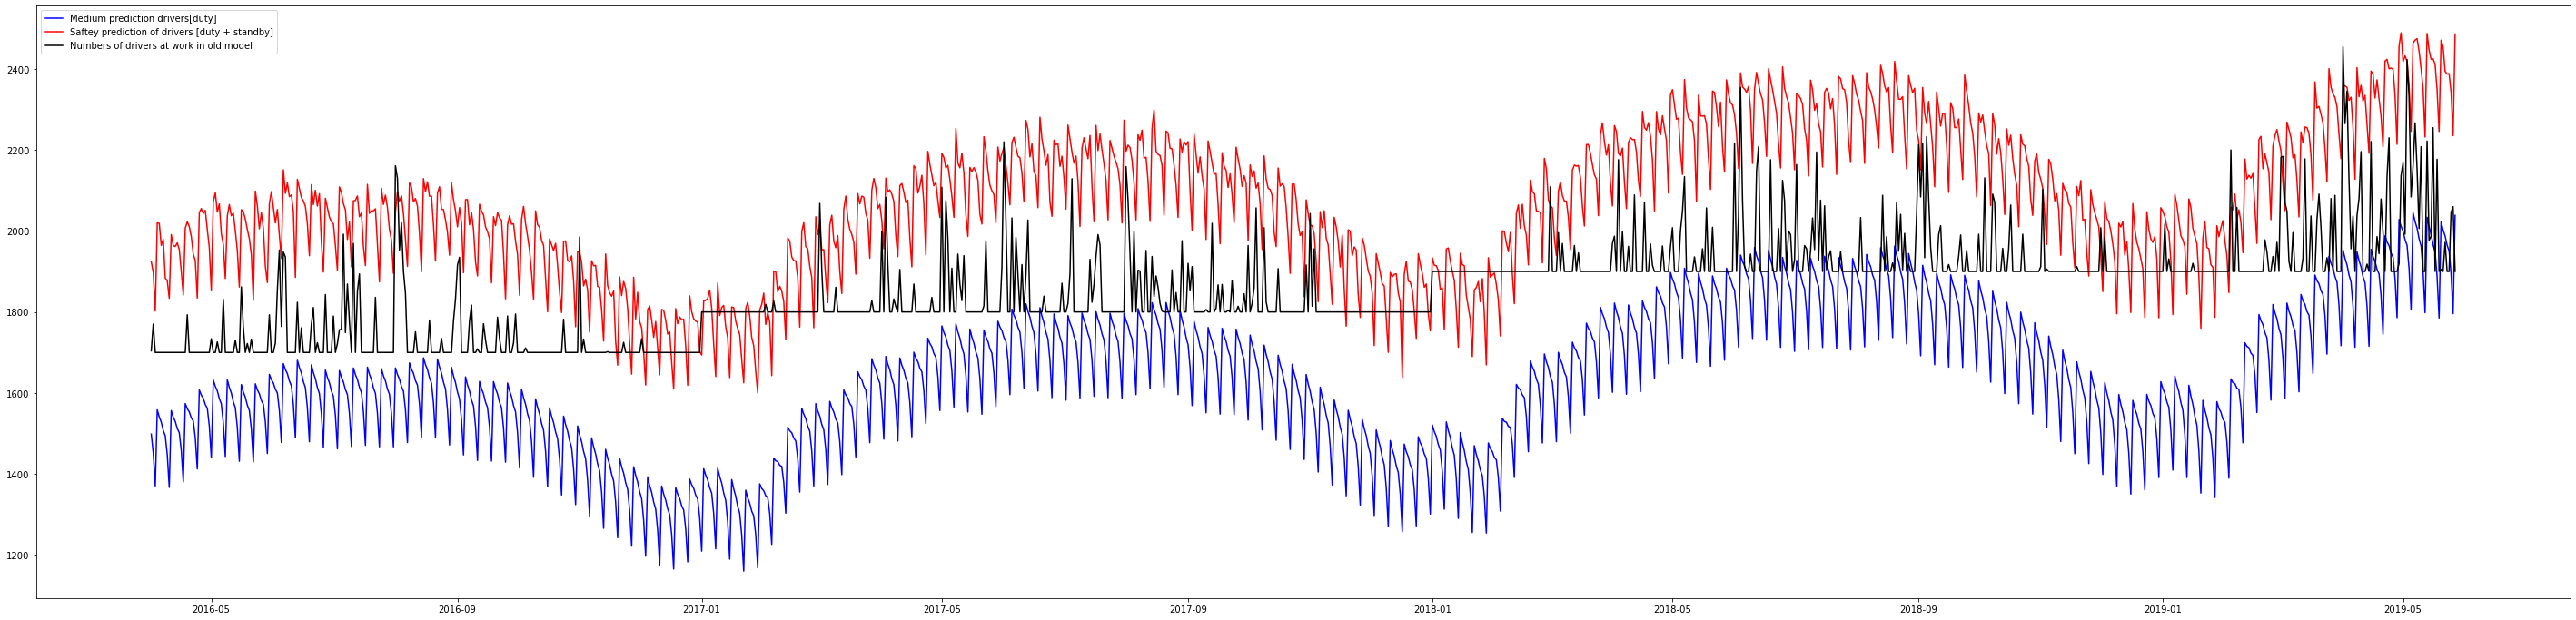

In [40]:
#Create the Prohpet-Model,with an interval_width of 97,5% (97,5% of the train values are in the predicted range) 
m = Prophet(interval_width=0.975, daily_seasonality=True,seasonality_mode="multiplicative")
# Train the Prophet-Model
m.fit(train)
# Create future datafame with xx days (periods & freq) as basis for prediction
future = m.make_future_dataframe(periods=365,freq='D')
# Make predictions for the created future dataframe
forecast = m.predict(future)
#plot the predictions 
forecast.set_index(forecast["ds"], inplace=True)
forecast["n_RealCalls"]=df["calls"]
forecast["drivers_atwork_old"]=df[["drivers_atwork"]]

fig = plt.figure(figsize=(50,12))
ax = fig.add_subplot(1, 1, 1)
ax.plot(forecast["ds"], forecast["yhat"]/x_Value,  label='Medium prediction drivers[duty]', c="blue")
ax.plot(forecast["ds"], forecast["yhat_upper"]/x_Value, label='Saftey prediction of drivers [duty + standby]', c="red")
ax.plot(forecast["ds"],forecast["drivers_atwork_old"],label="Numbers of drivers at work in old model", c="black")
ax.legend(loc='upper left')



#### Calculation of the root mean square error

In [41]:
pred=forecast["yhat"].iloc[len(forecast)-365:].values
try:
    rmse_value=rmse(pred,test['y'].values)
except: 
    rmse_value=0
print(f' The root mean square error is: {rmse_value}')

 The root mean square error is: 1012.0483883515906


#### Prophets Diagnostic Crossvalidation

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-05-27 00:00:00 and 2017-05-27 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\niels\anaconda3\envs\tsa_course_env_V3\lib\site-packages\fbprophet\plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
C:\Users\niels\anaconda3\envs\tsa_course_env_V3\lib\site-packages\fbprophet\plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


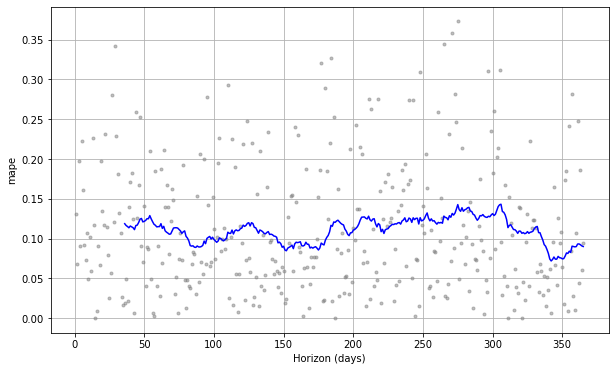

In [42]:
# Initial 1 years training period
initial = 1 * 365.25
initial = str(initial) + ' days'
# Fold every year
period = 1 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon)
plot_cross_validation_metric(df_cv, metric='mape');